# ✏️ Basic Setting

## 🔎 Data mount

보안상의 이유로 스킵

## 🔎 Importing Libraries and Functions

In [ ]:
# check GPU
!nvidia-smi

Sat Oct 31 03:47:00 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    22W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
%cd /content/
#lgbm with gpu on colab
!git clone https://github.com/Microsoft/LightGBM
%cd /content/LightGBM
!mkdir build
!cmake -DUSE_GPU=1
!make -j$(nproc)
!sudo apt-get -y install python-pip
!sudo -H pip install setuptools pandas numpy scipy scikit-learn -U
%cd /content/LightGBM/python-package
!sudo python setup.py install
!pip3 uninstall scikit-learn
!pip3 install scikit-learn==0.21.3

/content
Cloning into 'LightGBM'...
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 19977 (delta 1), reused 2 (delta 0), pack-reused 19970
Receiving objects: 100% (19977/19977), 15.82 MiB | 13.15 MiB/s, done.
Resolving deltas: 100% (14566/14566), done.
/content/LightGBM
-- The C compiler identification is GNU 7.5.0
-- The CXX compiler identification is GNU 7.5.0
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compiler: /usr/bin/cc -- works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /usr/bin/c++
-- Check for working CXX compiler: /usr/bin/c++ -- works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Found OpenMP_C: -fopenmp (found versi

In [ ]:
def multiclass_roc_auc_score(y_test, y_pred, average='macro'):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    return roc_auc_score(y_test, y_pred, average=average)

In [ ]:
class preprocessing_test:
  
  def __init__(self, df, GPU=True):
    self.df = df
    self.device = 'gpu' if GPU == True else 'cpu'
    self.tree_method = 'gpu_hist' if GPU==True else 'auto'
    X = self.df.iloc[:, 1:].values; y = self.df.iloc[:, 0].values
    self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1234)

  def LIFT20 (self,original_df, y_test, y_pred):
    
    LIFT_value = []

    total_data = len(original_df)
    predict_df = pd.DataFrame(data = y_pred, columns=['가맹점0','가맹점1','가맹점2','가맹점3','가맹점4','가맹점5',
                                   '가맹점6','가맹점7','가맹점8','가맹점9','가맹점10'])
    predict_df['y_test'] = y_test
    for classes in range(11):
        df = predict_df.sort_values(by=['가맹점%s'%classes], ascending=False)
        df = df[:int(len(predict_df)*0.2)]
        
        denominator = len(original_df[original_df['MRC_ID_DI']==int(classes)])/total_data
        numerator = len(df[df['y_test'] == classes])/int(len(predict_df)*0.2)
        LIFT_value.append(numerator/denominator)
    
    
    #결과 출력부
    for i in range(11):
      print('\033[36m' + '가맹점 %d_LIFT =\t\t'%i + str(round(LIFT_value[i], 4)) + '\033[0m') 
    print('\033[33m' + 'Mean_LIFT =\t\t' + str(round(np.mean(LIFT_value), 4)) + '\033[0m', sep='\n')

        
    #print(LIFT_value, np.mean(LIFT_value))
  
  def multiclass_roc_auc_score(self,y_test, y_pred_proba, average=None): #average='macro' when you wanna get mean
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    #y_pred = lb.transform(y_pred)   #if y_pred_proba is not a probability
    roc_auc = roc_auc_score(y_test, y_pred_proba, average=average)

    #결과 출력부
    for i in range(11):
      print('\033[36m'+'가맹점 %d_rocauc =\t'%i + str(round(roc_auc[i], 4))+'\033[0m') 
    print('\033[33m' + 'Mean_rocauc =\t\t' + str(round(np.mean(roc_auc), 4)) + '\033[0m', sep='\n')

  def lgbm_test(self):


    lgbm = LGBMClassifier(device=self.device, seed=1234)
    %time lgbm.fit(self.X_train, self.y_train)
    y_pred = lgbm.predict_proba(self.X_test)

    #lgbm 결과 출력
      #roc_auc
    print('\033[1m' + '\033[91m'+'Result of lgbm_model'+'\033[0m')
    self.multiclass_roc_auc_score(self.y_test, y_pred)
      #LIFT@20
    self.LIFT20(self.df, self.y_test,y_pred)

  def xgb_test(self):
    #X = self.df.iloc[:, 1:].values; y = self.df.iloc[:, 0].values
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1234)
    
    xgb = XGBClassifier(random_state=1234, tree_method=self.tree_method)
    %time xgb.fit(self.X_train, self.y_train, verbose=True)
    y_pred = xgb.predict_proba(self.X_test)

    #xgb 결과 출력
      #roc_auc
    print('\033[1m'+'\033[91m'+'Result of xgb_model'+'\033[0m')
    self.multiclass_roc_auc_score(self.y_test, y_pred)
      #LIFT@20
    self.LIFT20(self.df, self.y_test,y_pred)

In [ ]:
def concat_array(X_cat, X_num):
    X = np.concatenate((X_cat, X_num), axis=1)
    return X

# ✏️ Modeling with Dimensionality reduction (without Categorical values)

## 🔎 PCA (lgbm, 28+79, 0.862)

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_num) 
print('선택한 차원(픽셀) 수 :', pca.n_components_)

선택한 차원(픽셀) 수 : 28


In [ ]:
X_cat.shape, X_pca.shape

((285006, 28), (285006, 79))

In [ ]:
X = concat_array(X_cat,X_pca)

In [ ]:
X.shape

(285006, 107)

Train model

In [ ]:
from lightgbm import LGBMClassifier
lgbm = LGBMClassifier()

In [ ]:
X.shape, y.shape

((285006, 107), (285006,))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [ ]:
%time lgbm.fit(X_train, y_train)

CPU times: user 3min 43s, sys: 418 ms, total: 3min 43s
Wall time: 1min 53s


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
y_pred = lgbm.predict_proba(X_test)

In [ ]:
print(multiclass_roc_auc_score(y_test, y_pred))

[0.8740328  0.83633984 0.96615651 0.8308414  0.8361509  0.88409674
 0.79908997 0.84085197 0.82386704 0.88719832 0.90724954]


In [ ]:
print(multiclass_roc_auc_score(y_test, y_pred, average='macro'))

0.8623522741366468


## 🔎 FA (lgbm, 28+17 dim, 0.833)

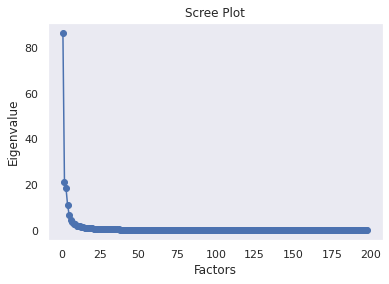

In [ ]:
from factor_analyzer import FactorAnalyzer
fa = FactorAnalyzer(rotation='varimax',  n_factors = 25)
fa.fit(X_num)

# 스크리 도표 그리기
ev, v = fa.get_eigenvalues()

plt.scatter(range(1,X_num.shape[1]+1),ev)
plt.plot(range(1,X_num.shape[1]+1),ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

In [ ]:
ev[ev>1]

array([86.50688849, 21.3347185 , 18.48372031, 11.29867479,  6.94569457,
        4.614856  ,  3.4955622 ,  2.94123787,  2.61155686,  2.14520864,
        2.05700392,  1.90344537,  1.59484875,  1.28499219,  1.15011584,
        1.05373462,  1.01364116])

In [ ]:
fa = FactorAnalyzer(rotation='varimax',  n_factors = 17)
%time fa.fit(X_num)

# Change column values with FA
%time X_fa = fa.transform(X_num)

CPU times: user 24.6 s, sys: 16 s, total: 40.6 s
Wall time: 21.1 s
CPU times: user 777 ms, sys: 108 ms, total: 884 ms
Wall time: 634 ms


Train model

In [ ]:
from lightgbm import LGBMClassifier
lgbm = LGBMClassifier()

In [ ]:
X = concat_array(X_cat,X_fa)

In [ ]:
X_cat.shape, X_fa.shape, X.shape

((285006, 28), (285006, 17), (285006, 45))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [ ]:
%time lgbm.fit(X_train, y_train)

CPU times: user 1min 16s, sys: 299 ms, total: 1min 16s
Wall time: 38.9 s


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
y_pred = lgbm.predict_proba(X_test)

In [ ]:
print(multiclass_roc_auc_score(y_test, y_pred))

[0.84561345 0.82764708 0.8798989  0.79553955 0.84291033 0.82486884
 0.77758875 0.81531694 0.80086561 0.8700439  0.88639549]


In [ ]:
print(multiclass_roc_auc_score(y_test, y_pred, average='macro'))

0.8333353485887599


## 🔎 FA (lgbm, 28+79 dim, 0.8575)

In [ ]:
X_num.shape, X_cat.shape

((285006, 198), (285006, 28))

In [ ]:
from factor_analyzer import FactorAnalyzer

fa = FactorAnalyzer(rotation='varimax',  n_factors = 79)
%time fa.fit(X_num)

# Change column values with FA
%time X_fa = fa.transform(X_num)

/usr/local/lib/python3.6/dist-packages/factor_analyzer/factor_analyzer.py:536: UserWarning: Failed to converge: b'STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT'
  warnings.warn('Failed to converge: {}'.format(res.message))


CPU times: user 3min 12s, sys: 3min 51s, total: 7min 3s
Wall time: 3min 35s
CPU times: user 1.21 s, sys: 187 ms, total: 1.39 s
Wall time: 934 ms


Train model

In [ ]:
X = concat_array(X_cat,X_fa)

In [ ]:
df_fa = pd.concat([df.iloc[:, :2],pd.DataFrame(X)], axis=1).set_index('cst_id_di')

In [ ]:
test = preprocessing_test(df_fa)
test.lgbm_test()

## 🔎 FA (xgb, 28+79 dim, 0.8724)

In [ ]:
from factor_analyzer import FactorAnalyzer

fa = FactorAnalyzer(rotation='varimax',  n_factors = 79)
%time fa.fit(X_num)

# Change column values with FA
%time X_fa = fa.transform(X_num)

In [ ]:
X = concat_array(X_cat,X_fa)

In [ ]:
X_cat.shape, X_fa.shape, X.shape

((285006, 28), (285006, 79), (285006, 107))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [ ]:
## Xgboost Classifier
from xgboost import XGBClassifier

model = XGBClassifier(tree_method="gpu_hist")
%time model.fit(X_train, y_train)

CPU times: user 19.8 s, sys: 10.9 s, total: 30.7 s
Wall time: 30.7 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, tree_method='gpu_hist', verbosity=1)

In [ ]:
y_pred = model.predict_proba(X_test)

In [ ]:
print(multiclass_roc_auc_score(y_test, y_pred))

[0.87090303 0.84362704 0.97229723 0.83785241 0.86046562 0.91170017
 0.79316218 0.83351163 0.81741626 0.91091695 0.94494349]


In [ ]:
print(multiclass_roc_auc_score(y_test, y_pred, average='macro'))

0.8724360016094899
